Are the contaminants being injected into the water column within the Salish Sea Atlantis Model within a timescale of 10 days as we might expect? 

How about uptake by the phytoplankton?

### Highres Tests
- v6699_16 - updated code version (see SSAM-output-biopools.ipynb)
- v6699_17 - updated code version + small number dummy contaminant file to zero out contaminants, but flag_dissolved_pollutants = 0
- highres3 - reduced uptake rates of PAH for diatoms and picos to around 8.0e-03 mg/m^3 per day
- v6699_17A - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 1
- v6699_17B - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18 - bm->dayt in decay calculation, flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18B - removed (/time_step) so that sp_amount_decayed = cGroupLevel - newValue
- v6699_18C - test to see if 18B still works if time_step = dt rather than dayt.
- v6699_18D - put time_step back to dt, but in atContaminants.c line 1094, instead of using cLevel in Calculate_Species_Contaminant_Decay, defined cGroupLevel = tracerArray[FunctGroupArray[sp].contaminantTracers[cohort][cIndex]]; and then defined the tracerArray as getTracerArray(boxLayerInfo, habitat) except for EPIFAUNA (getTracerArray(boxLayerInfo, WC))
- v6699_18E - added a decay_constant defined by the half-life, and defined the new_value = cGroupLevel * decay_constant * time_step;
- v6699_18F - tracerArray = getTracerArray(boxLayerInfo, habitat); left off bit about epifauna as it crashed the longer runs.
- v6699_18G - return half_life equation to original while leaving other changes
- v6699_19A - remove ability of contaminants pass from detritus to bio through predation + turned on flag_dissolved_pollutants
- v6699_20 - remove ability of contaminants to pass back to the water column

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from PIL import Image
import glob
from IPython.display import Image as img
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [19]:
control_name = 'v6699_20_highres_single_injection'
test_name = 'v6699_20_highres_single_injection_phytop'
test2_name = 'v6699_20_highres_single_injection_zoop'
#test3_name = 'v6699_20_highres_B'
#labels = [control_name,test_name,test2_name, test3_name]
#testlabels = [test_name, test2_name, test3_name]

In [3]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [4]:
time_c = np.ma.filled(control.variables['t'], np.nan)

In [21]:
test_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test_name + "/outputSalishSea.nc"
test2_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test2_name + "/outputSalishSea.nc"
test = xr.open_dataset(str(test_path), decode_cf=True)
test2= xr.open_dataset(str(test2_path), decode_cf=True)

In [ ]:
test3_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test3_name + "/outputSalishSea.nc"
test3= xr.open_dataset(str(test3_path), decode_cf=True)

In [6]:
time = np.ma.filled(test.variables['t'], np.nan)

In [22]:
scenarios = [control, test, test2]
scens = [test, test2]
#scen3 = [test3]
cont = [control]

In [23]:
labels = ['single injection, uptake + transfer','single injection, phytop uptake only + transfer','single injection, zoop uptake only + transfer']
testlabels = ['single injection, phytop uptake only + transfer','single injection, zoop uptake only + transfer']

### Functions

In [9]:
def plot_pah(scenario, times, label):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [10]:
def plot_individual_pah(scenario, times, label, pah):
    fig, ax = plt.subplots(figsize = (14,3))
    contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(pah)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [11]:
def tissue_mass(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
            oil_mass_tbl = oil_tbl * volume_tbl
            oil_mass_tb = oil_mass_tbl.sum(axis=2) 
            oil_mass_t = oil_mass_tb.sum(axis=1) 
            ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
        
        #plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
    #print(sp_volume_tbl[1,60,:])
    #print(sp_volume_tbl[1,60,:]+(sp_volume_tbl[3,60,:]==0))

In [12]:
def individual_tissue_mass(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [13]:
def individual_tissue_mass_log(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.semilogy(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5)
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [14]:
def tissue_mass_log(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan)
            oil_per_N_tbl = oil_tbl * (1/(volume_tbl+(volume_tbl==0)))
            oil_per_N_tb = oil_per_N_tbl.sum(axis=2) 
            oil_per_N_t = oil_per_N_tb.sum(axis=1) 
            ax.semilogy(time, oil_per_N_t[0:time.size],linewidth = 2, alpha=0.5)
        
        plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [ ]:
def plot_biomass(group, scens, names=labels):
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2)
            pelagic_oiled = pelagic_oiled.sum(axis=1)
            ax.plot(time, pelagic_oiled[0:time.size], linewidth = 2)
        
        plt.ylabel('mg N m$^{-3}$', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [ ]:
def map_tissue_mass(group, pah, scenarios, v_max=None, v_min=None, _cmap=cm.Purples):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(group), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for species in group:
        for scenario in scenarios:
            dVar_s = scenario.variables[group[species] + '_' + pah][:,:,0:6]
            volume = scenario.variables['volume'][:,:,0:6]
            #dVar_s = dVar_s.sum(axis=2)
            dVar_mass = dVar_s * volume
            vpah_tb = dVar_mass.sum(axis=2)
            vpah_b = vpah_tb.sum(axis=0)

            # Add scenario data to Atlantis spatial data
            map_df['pah'] = vpah_b
            map_df.loc[land_boxes, 'pah'] = 0

            ax = fig.add_subplot(gs[0, position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
                legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
                )
            tit = str(species + '_' + pah)
            ax.set_title(tit)
            map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');
        position=position+1

In [ ]:
def map_aggregate_time(variable_name, scens, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.mean(axis=2)
        pah = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(names[scenario.index], fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

In [ ]:
def map_time_mass(variable_name, scens, time, names=labels, v_max=None, v_min=None):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        var_bl = scenario.variables[variable_name][time,:,0:6]
        vol_bl = scenario.variables['volume'][time,:,0:6]
        var_mass_bl = var_bl * vol_bl
        var_mass_b = var_mass_bl.mean(axis=1)

        # Add scenario data to Atlantis spatial data
        map_df[variable_name] = var_mass_b
        map_df.loc[land_boxes, variable_name] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = variable_name, cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(variable_name, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
    fig.suptitle(names)

In [ ]:
def map_time_depth(variable_name, scens, time, depth, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    depth_range = ['700 m','400 m', '250 m', '100 m', '50 m', 'surface 25 m', 'sediment']
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name][time,:,depth]
        #dVar_s = dVar_s.mean(axis=1)
        #pah_s = dVar_s.mean(axis=1)
        pah_s = dVar_s

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah_s
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title((variable_name + ' - ' + depth_range[depth] + '_' + str(time)), fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
        map_df['pah'] = 0

### Water Column - without resets

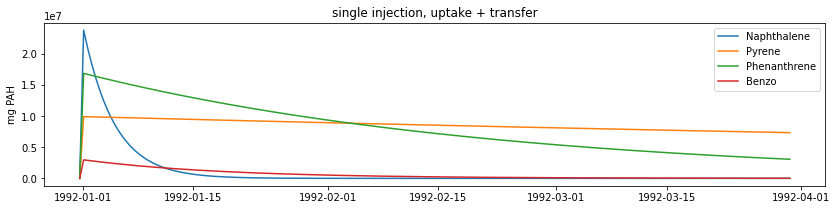

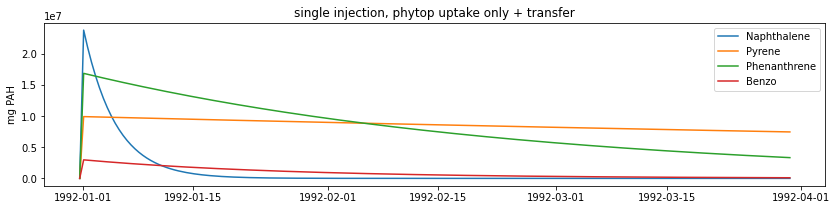

In [15]:
for test, name in zip (scenarios, labels):
    plot_pah(test, time, label=name)

### Phytoplankton

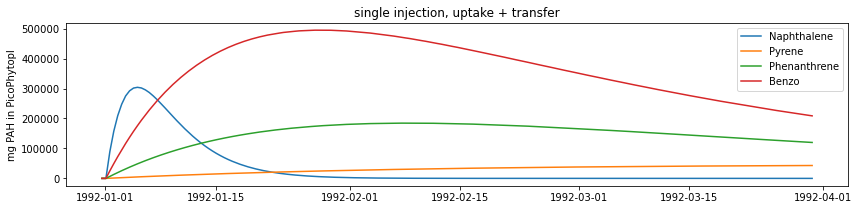

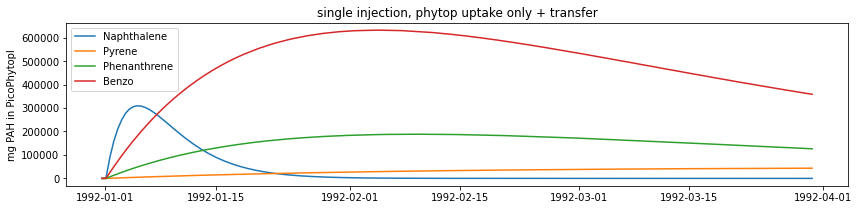

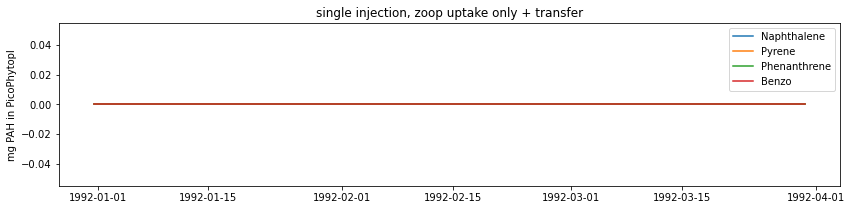

In [24]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'PicoPhytopl_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in PicoPhytopl')
    ax.set_title(label);

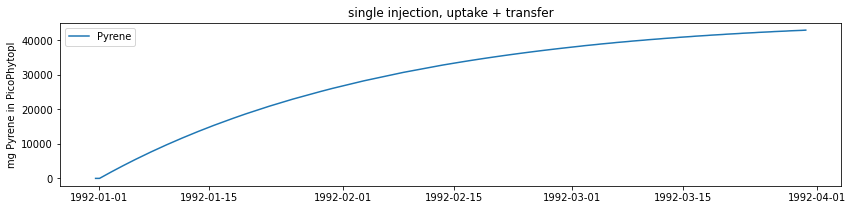

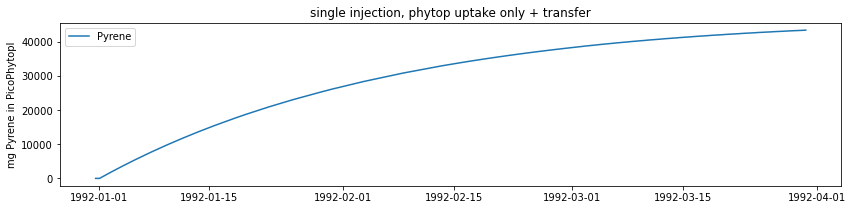

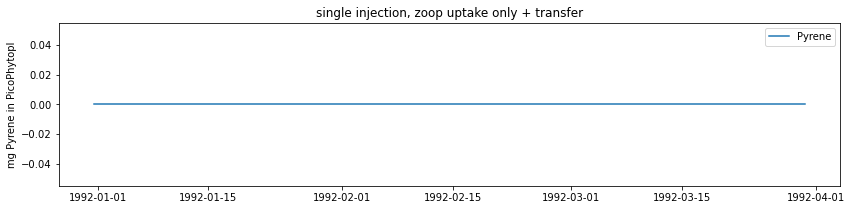

In [25]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    name = 'PicoPhytopl_Pyrene'
    contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(['Pyrene'])
    ax.set_ylabel('mg Pyrene in PicoPhytopl')
    ax.set_title(label);

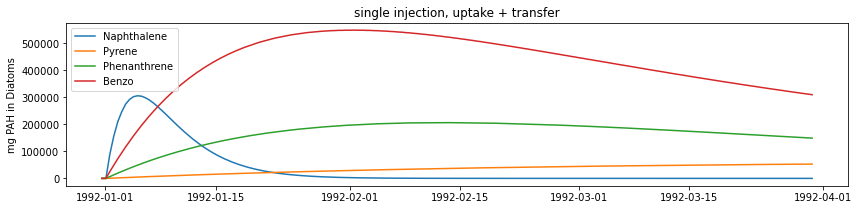

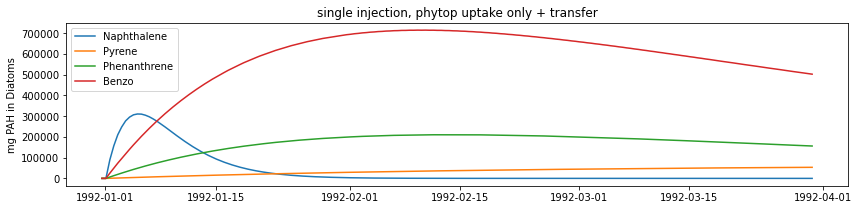

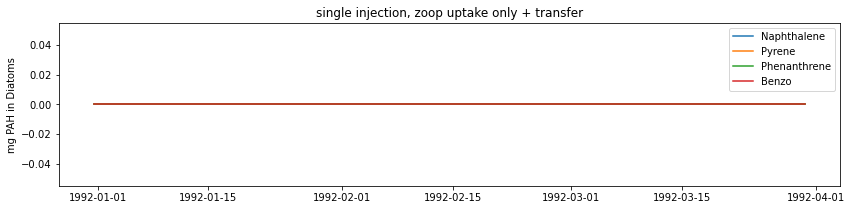

In [26]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Diatom_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Diatoms')
    ax.set_title(label);

without zooplankton uptake, there is more Benzo left in the water column for phytop, and the maximum amount is larger

### Zooplankton

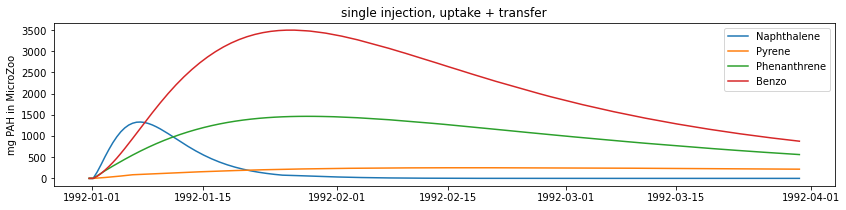

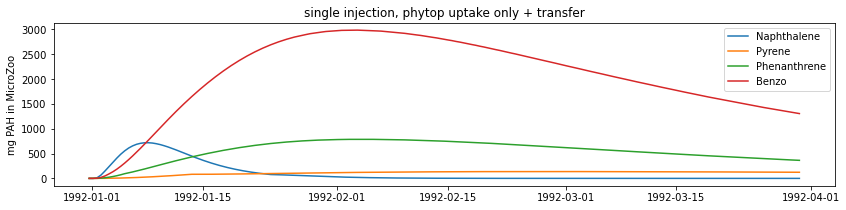

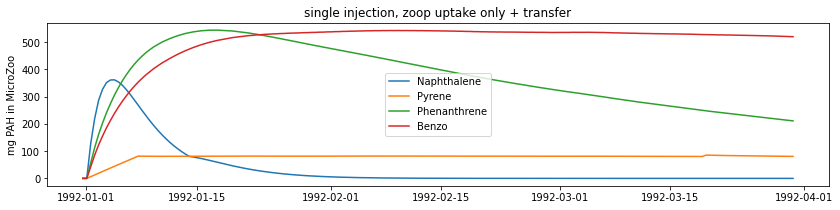

In [27]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'MicroZoo_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in MicroZoo')
    ax.set_title(label);

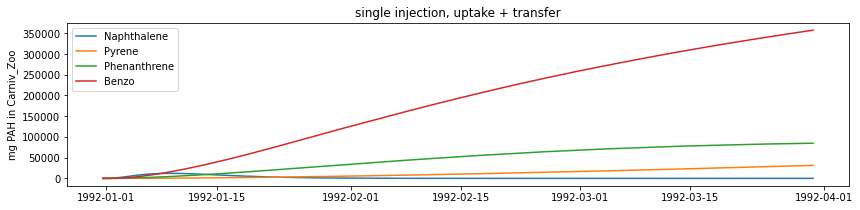

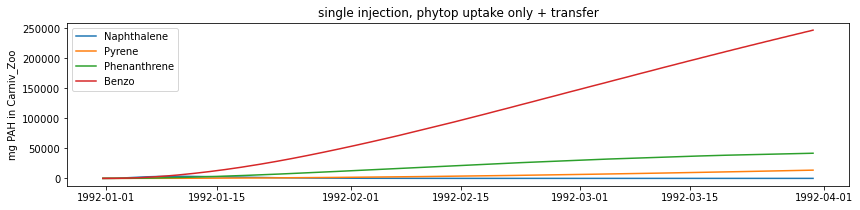

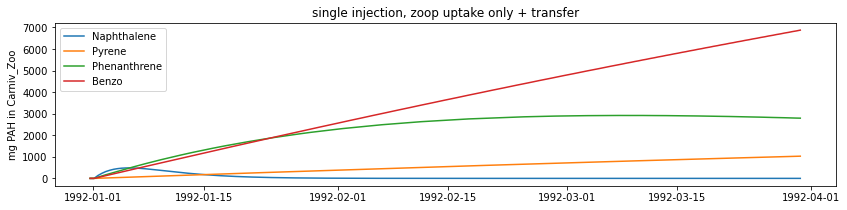

In [28]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Carniv_Zoo_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Carniv_Zoo')
    ax.set_title(label);

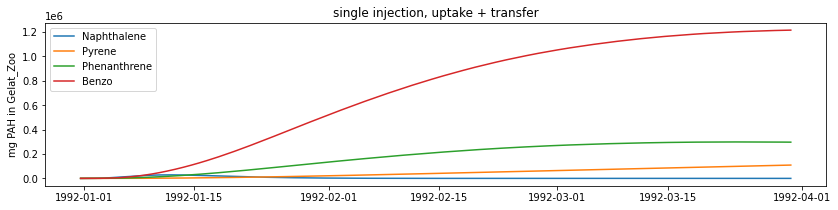

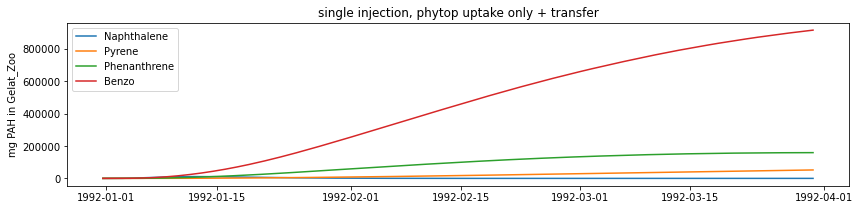

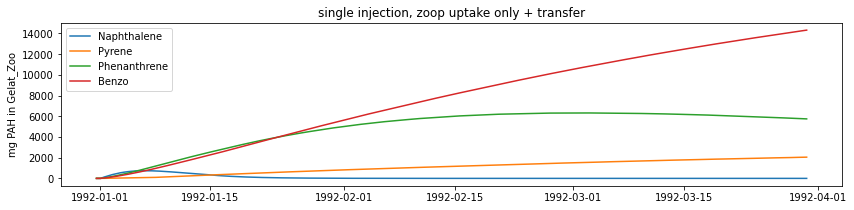

In [29]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Gelat_Zoo_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Gelat_Zoo')
    ax.set_title(label);

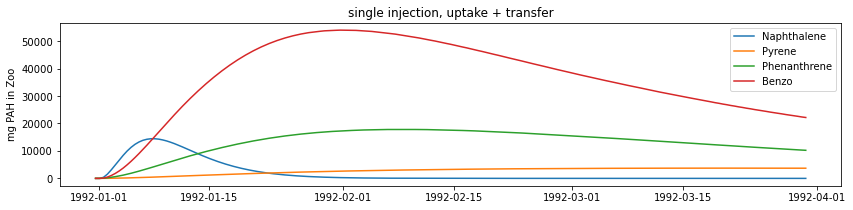

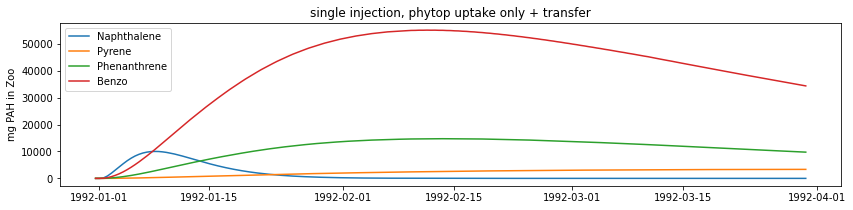

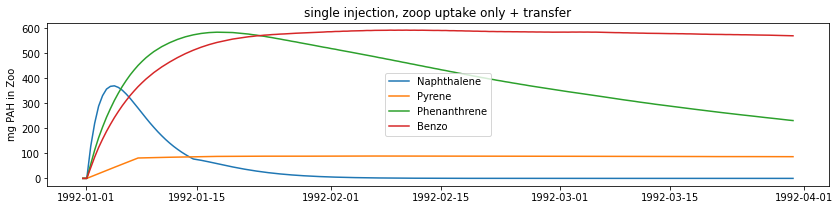

In [30]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Zoo_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Zoo')
    ax.set_title(label);

### Pelagic Bacteria

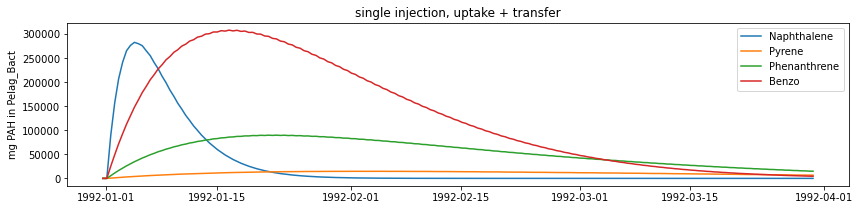

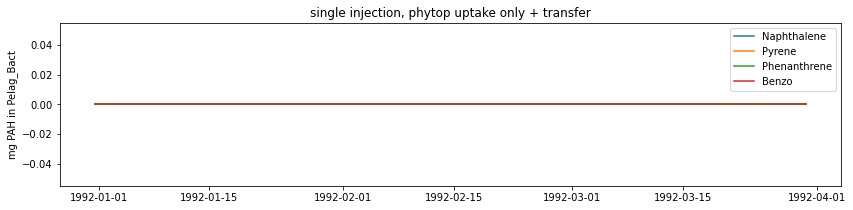

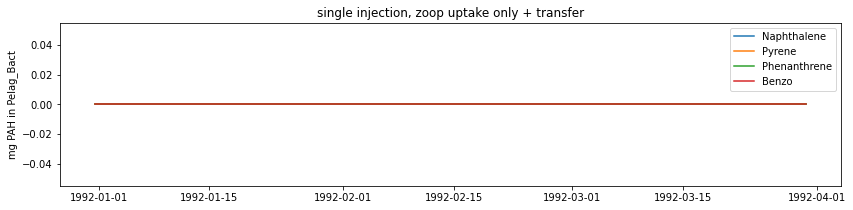

In [31]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Pelag_Bact_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Pelag_Bact')
    ax.set_title(label);

### Comparison of PAH mass inside plankton

In [32]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        name = 'Diatom_' + pah
        contam_bl = np.ma.filled(scenario.variables[name][9,:,0:6], np.nan)
        volume_bl = np.ma.filled(scenario.variables['volume'][9,:,0:6], np.nan)
        contam_mass_bl = contam_bl * volume_bl
        contam_mass_b = contam_mass_bl.sum(axis=1)
        contam_mass = contam_mass_b.sum(axis=0)
        print(label, name, contam_mass)

single injection, uptake + transfer Diatom_Naphthalene 305504.3068173441
single injection, uptake + transfer Diatom_Pyrene 4883.429519595935
single injection, uptake + transfer Diatom_Phenanthrene 48833.77142997864
single injection, uptake + transfer Diatom_Benzo 176700.30440501843
single injection, phytop uptake only + transfer Diatom_Naphthalene 310644.52530133916
single injection, phytop uptake only + transfer Diatom_Pyrene 4884.970295263234
single injection, phytop uptake only + transfer Diatom_Phenanthrene 48915.440026059856
single injection, phytop uptake only + transfer Diatom_Benzo 182511.53426451847
single injection, zoop uptake only + transfer Diatom_Naphthalene 0.0
single injection, zoop uptake only + transfer Diatom_Pyrene 0.0
single injection, zoop uptake only + transfer Diatom_Phenanthrene 0.0
single injection, zoop uptake only + transfer Diatom_Benzo 0.0


In [33]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        name = 'PicoPhytopl_' + pah
        contam_bl = np.ma.filled(scenario.variables[name][9,:,0:6], np.nan)
        volume_bl = np.ma.filled(scenario.variables['volume'][9,:,0:6], np.nan)
        contam_mass_bl = contam_bl * volume_bl
        contam_mass_b = contam_mass_bl.sum(axis=1)
        contam_mass = contam_mass_b.sum(axis=0)
        print(label, name, contam_mass)

single injection, uptake + transfer PicoPhytopl_Naphthalene 304141.29446353065
single injection, uptake + transfer PicoPhytopl_Pyrene 4864.21455780629
single injection, uptake + transfer PicoPhytopl_Phenanthrene 48640.215915168905
single injection, uptake + transfer PicoPhytopl_Benzo 176010.79474346607
single injection, phytop uptake only + transfer PicoPhytopl_Naphthalene 309257.3389228784
single injection, phytop uptake only + transfer PicoPhytopl_Pyrene 4865.748837541089
single injection, phytop uptake only + transfer PicoPhytopl_Phenanthrene 48721.53788119489
single injection, phytop uptake only + transfer PicoPhytopl_Benzo 181796.9965425786
single injection, zoop uptake only + transfer PicoPhytopl_Naphthalene 0.0
single injection, zoop uptake only + transfer PicoPhytopl_Pyrene 0.0
single injection, zoop uptake only + transfer PicoPhytopl_Phenanthrene 0.0
single injection, zoop uptake only + transfer PicoPhytopl_Benzo 0.0


In [48]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        mass = 0
        for species in ['PicoPhytopl','Diatom', 'Carniv_Zoo', 'Gelat_Zoo', 'MicroZoo','Zoo','Pelag_Bact','Squid','Prawn']:    
            name = species + '_' + pah
            contam_bl = np.ma.filled(scenario.variables[name][time.size-1,:,0:6], np.nan)
            volume_bl = np.ma.filled(scenario.variables['volume'][time.size-1,:,0:6], np.nan)
            contam_mass_bl = contam_bl * volume_bl
            contam_mass_b = contam_mass_bl.sum(axis=1)
            contam_mass = contam_mass_b.sum(axis=0)
            mass = mass + contam_mass
        print(label, pah, mass)

single injection, uptake + transfer Naphthalene 0.017253288968280198
single injection, uptake + transfer Pyrene 258512.22789387414
single injection, uptake + transfer Phenanthrene 704705.6739126716
single injection, uptake + transfer Benzo 2158907.070337656
single injection, phytop uptake only + transfer Naphthalene 0.014066994436918816
single injection, phytop uptake only + transfer Pyrene 169540.8737978453
single injection, phytop uptake only + transfer Phenanthrene 503527.2271481167
single injection, phytop uptake only + transfer Benzo 2098191.597453861
single injection, zoop uptake only + transfer Naphthalene 6.986536824584602e-05
single injection, zoop uptake only + transfer Pyrene 3339.933869308049
single injection, zoop uptake only + transfer Phenanthrene 9106.033920357257
single injection, zoop uptake only + transfer Benzo 22590.563275847966


At the end of the run, the entire plankton (phytop, zoop, bacteria, squid and prawn) contained a combined 40% of the initial Benzo mass released when forced removal is not present and the contaminant remains in the water due to a long half-life

### Other visuals

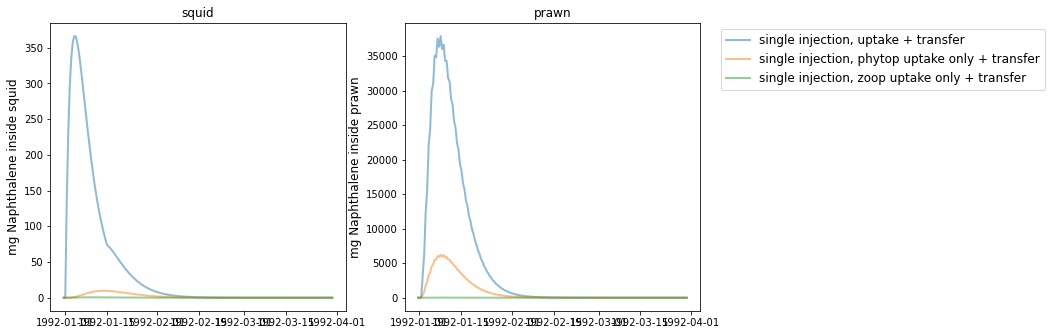

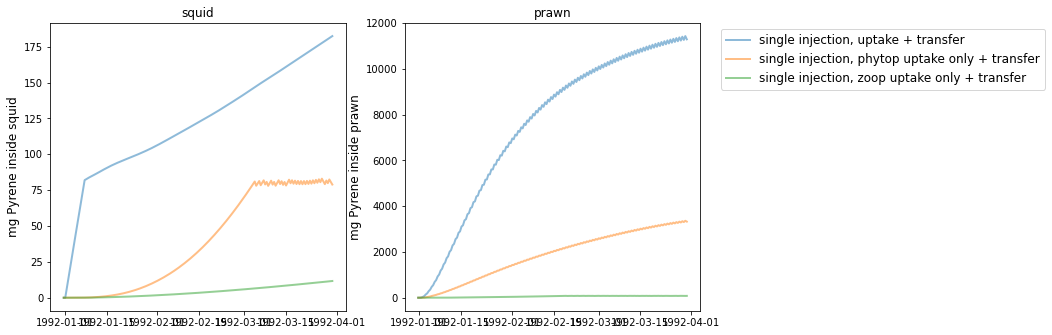

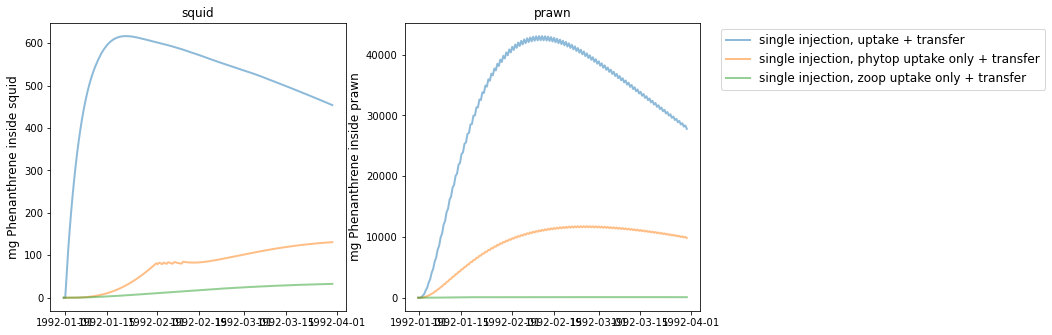

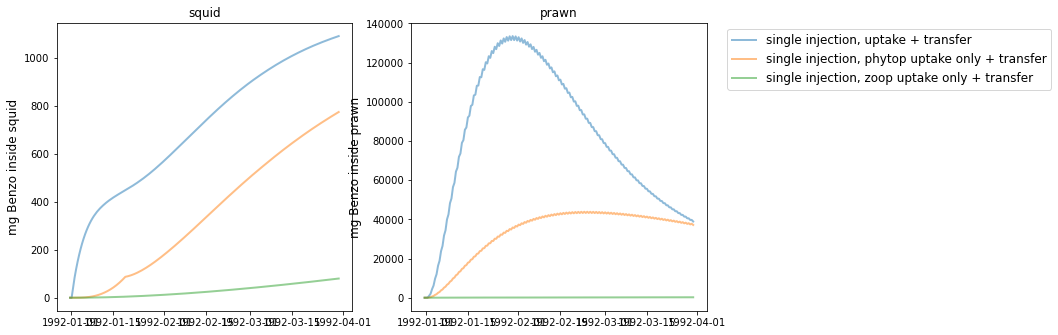

In [35]:
for pah in groups.pahs:
    tissue_mass(groups.pelagic_invertebrates, pah, scenarios, labels)

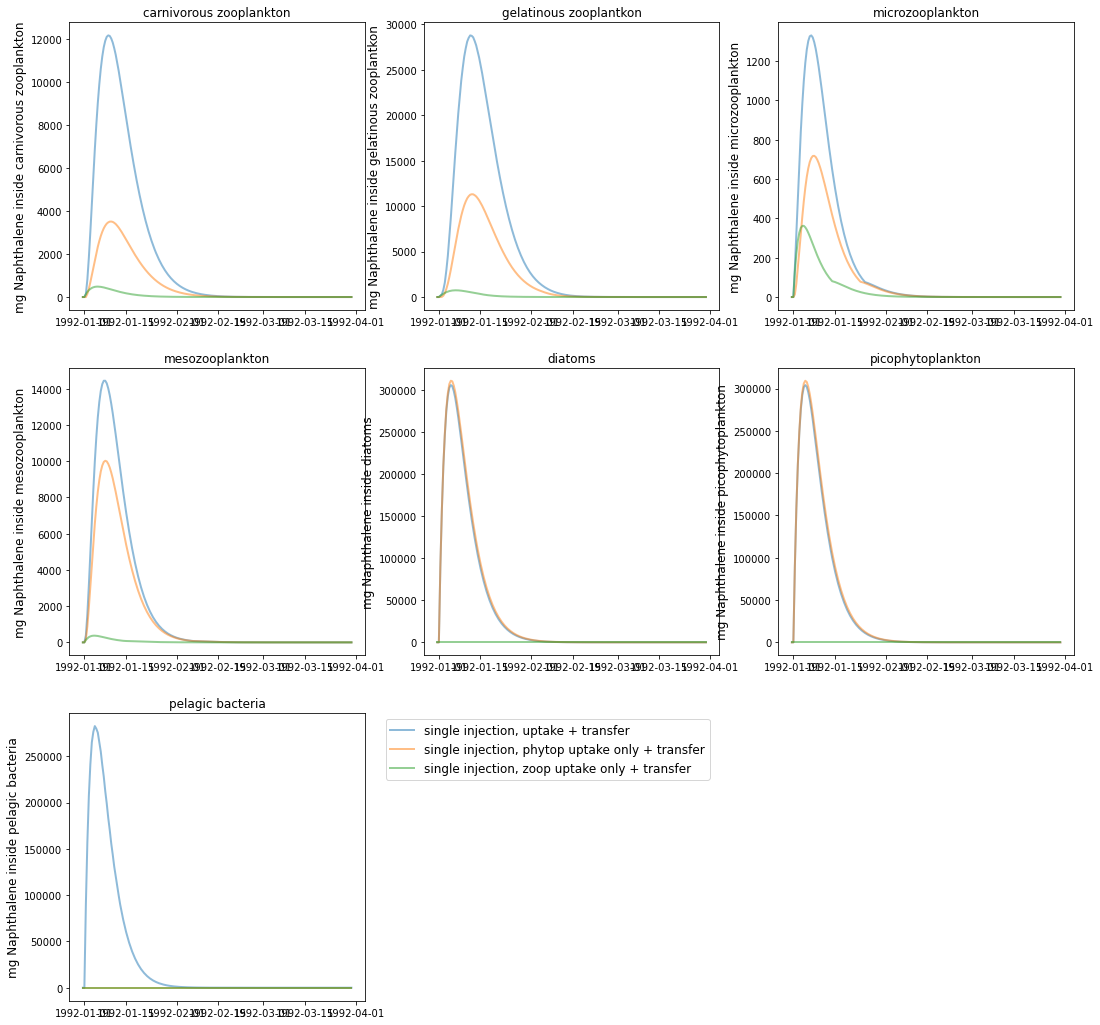

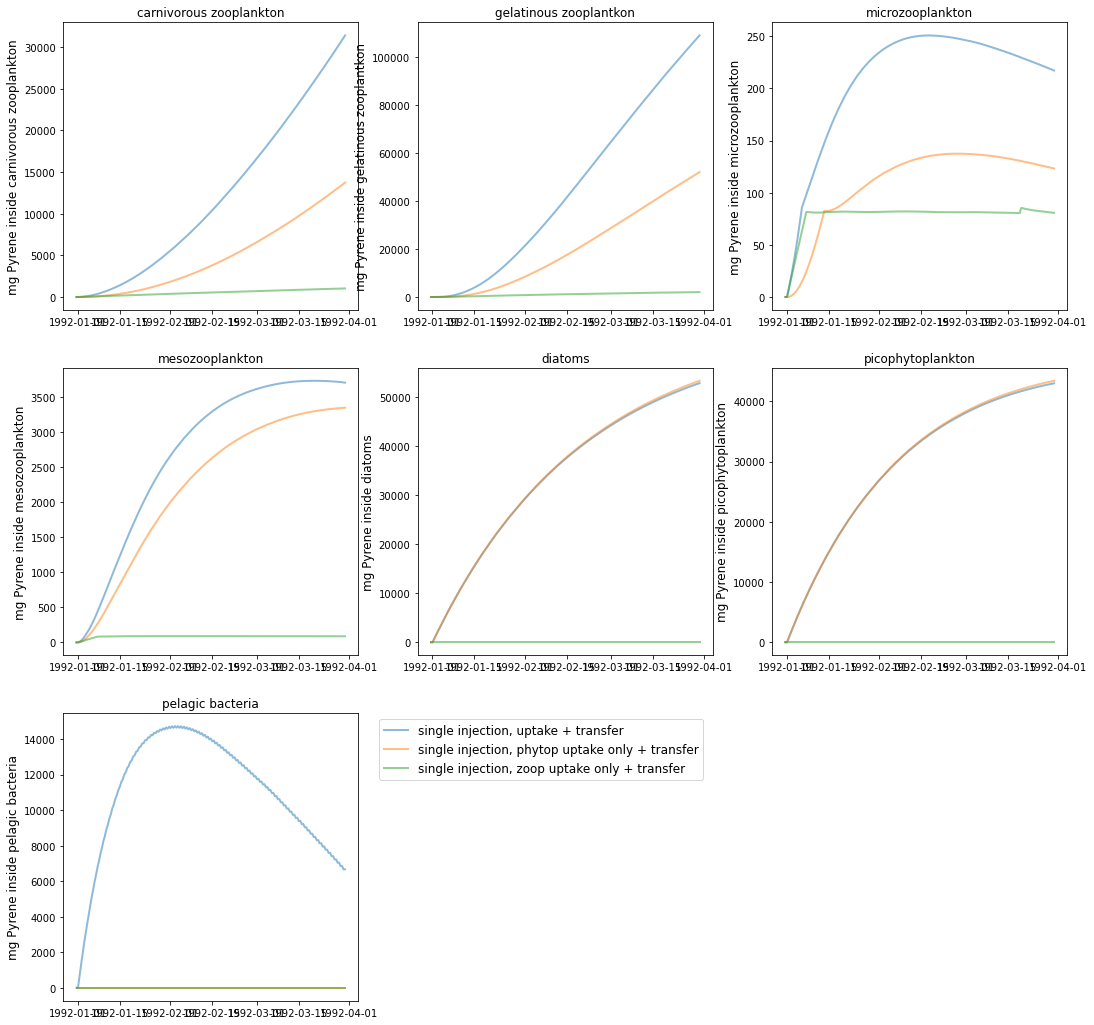

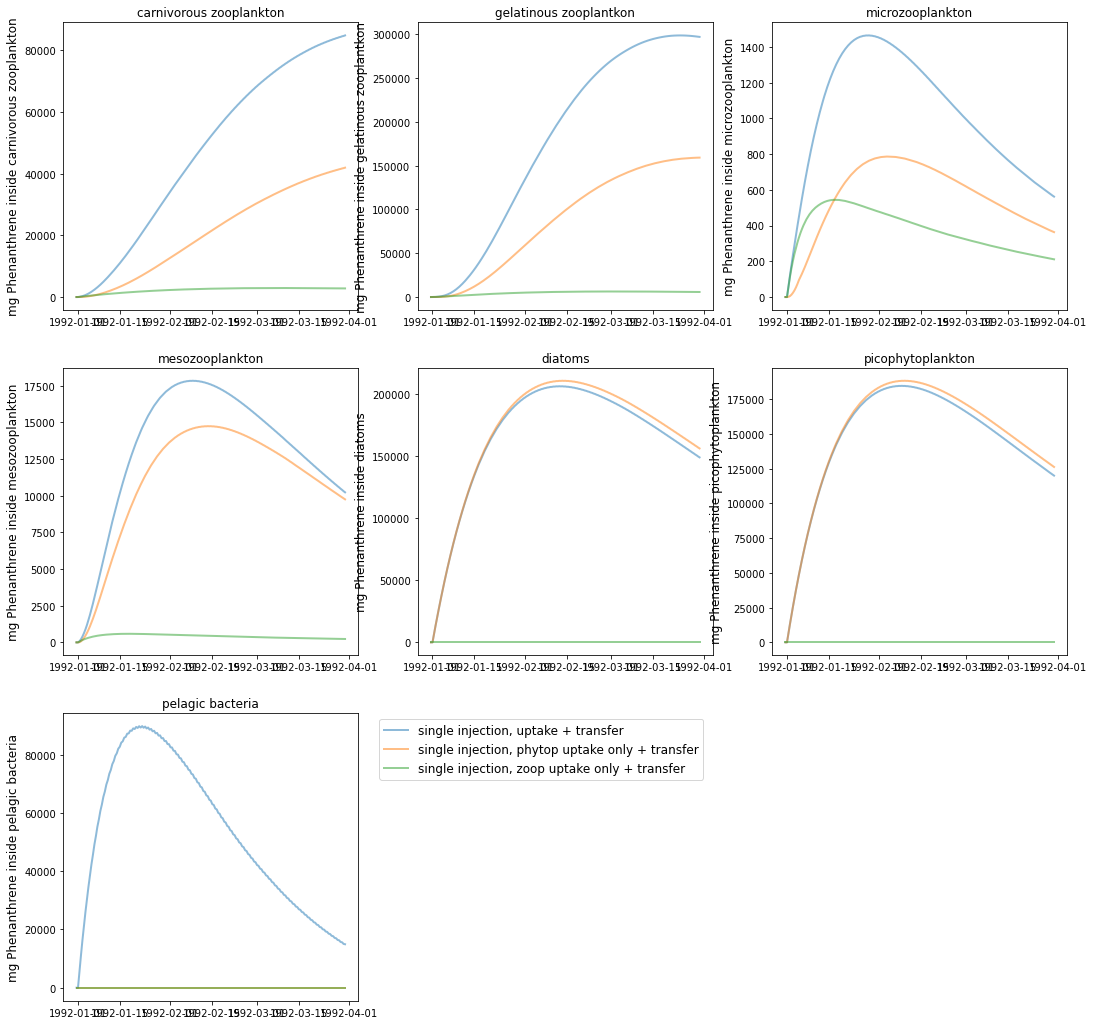

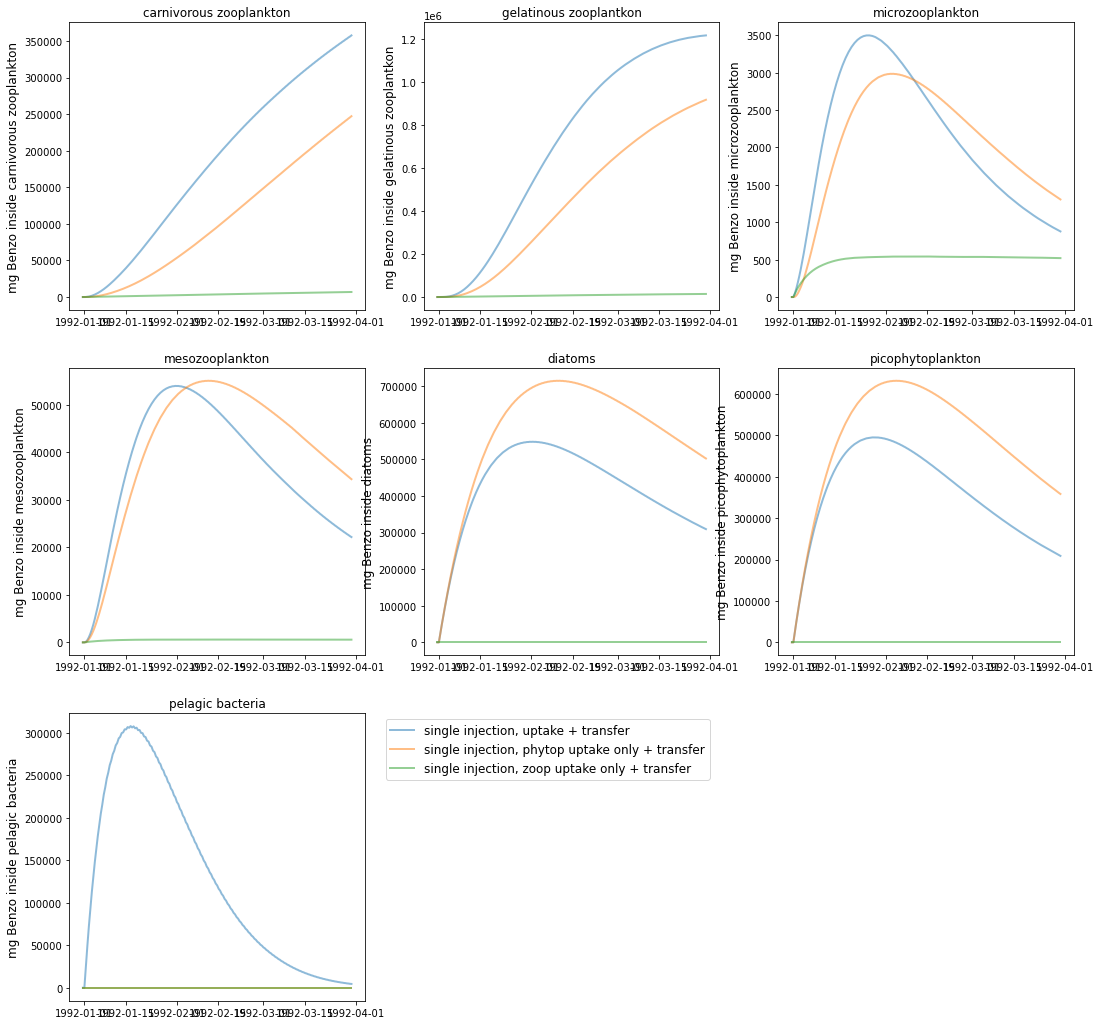

In [36]:
for pah in groups.pahs:
    tissue_mass(groups.plankton, pah, scenarios, labels)

In [37]:
def tissue_vertebrate_mass(group, pah, scenarios, labels):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:

        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        numCohorts = groups.cohorts[group[species]]

        for scenario in scenarios:
            oiled_cohort = np.zeros(len(time))
            for cohort in range (1, numCohorts+1):

                new_species = group[species] + str(cohort)
            
                oiled_species = np.ma.filled(scenario.variables[new_species + '_' + pah][:,:,:], np.nan)
                volume = np.ma.filled(scenario.variables['volume'][:,:,:], np.nan)
                oiled_mass_tbl = oiled_species * volume
                oiled_mass_tb = oiled_mass_tbl.sum(axis=2)
                oiled_mass_t = oiled_mass_tb.sum(axis=1)

                oiled_cohort = oiled_cohort + oiled_mass_t
            ax.plot(time, oiled_cohort, linewidth = 2, alpha=0.6) #semilogy
        
        plt.ylabel('mg ' + pah + ' in tissue', fontsize=12)
        ax.set_title(species);
    ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

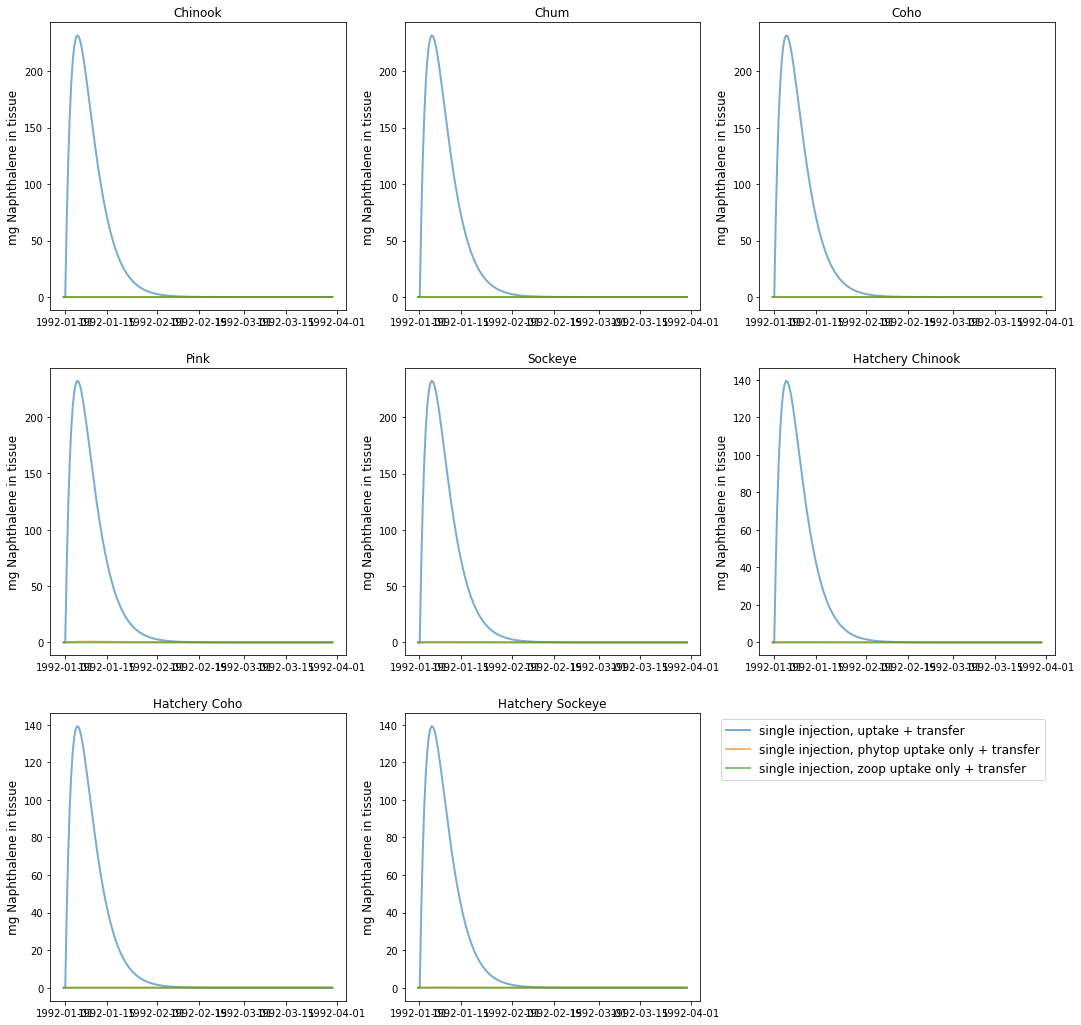

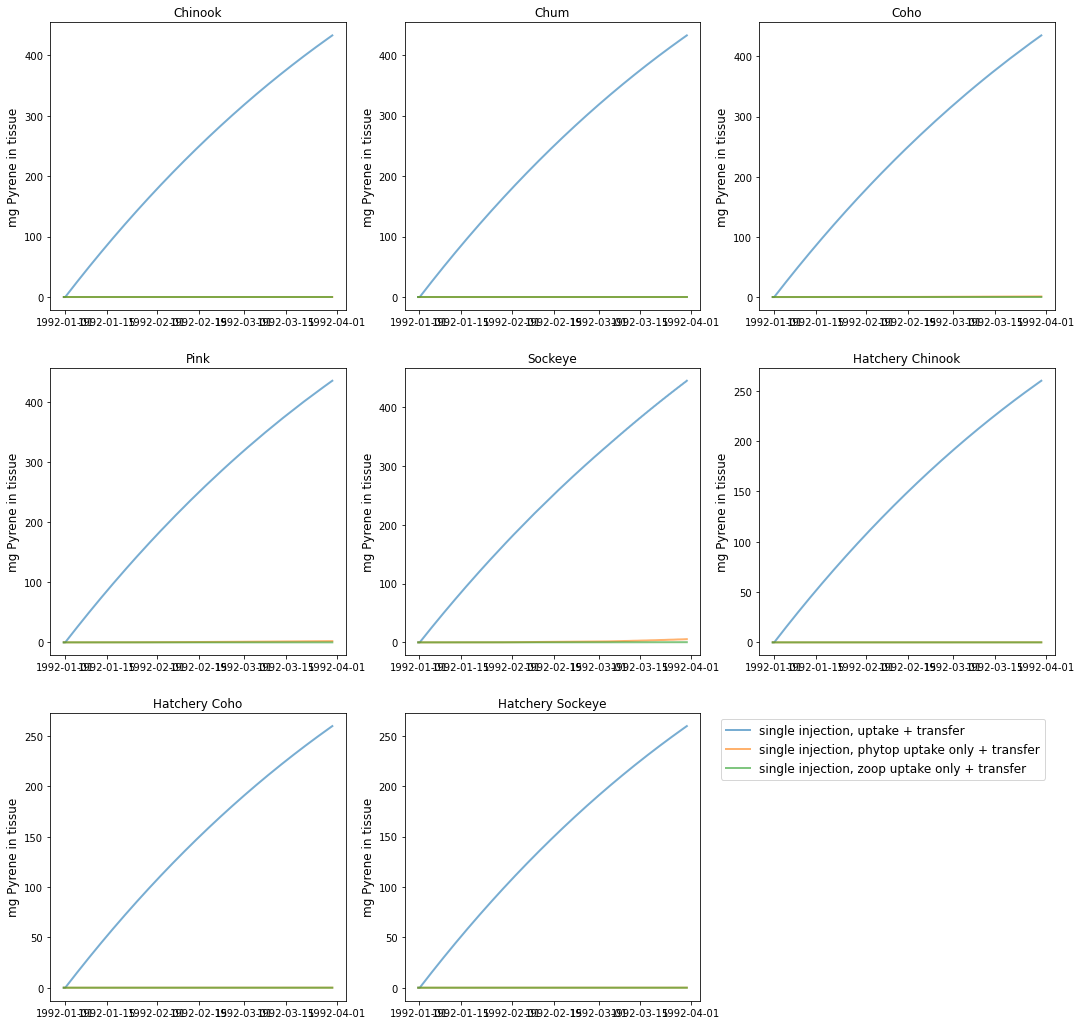

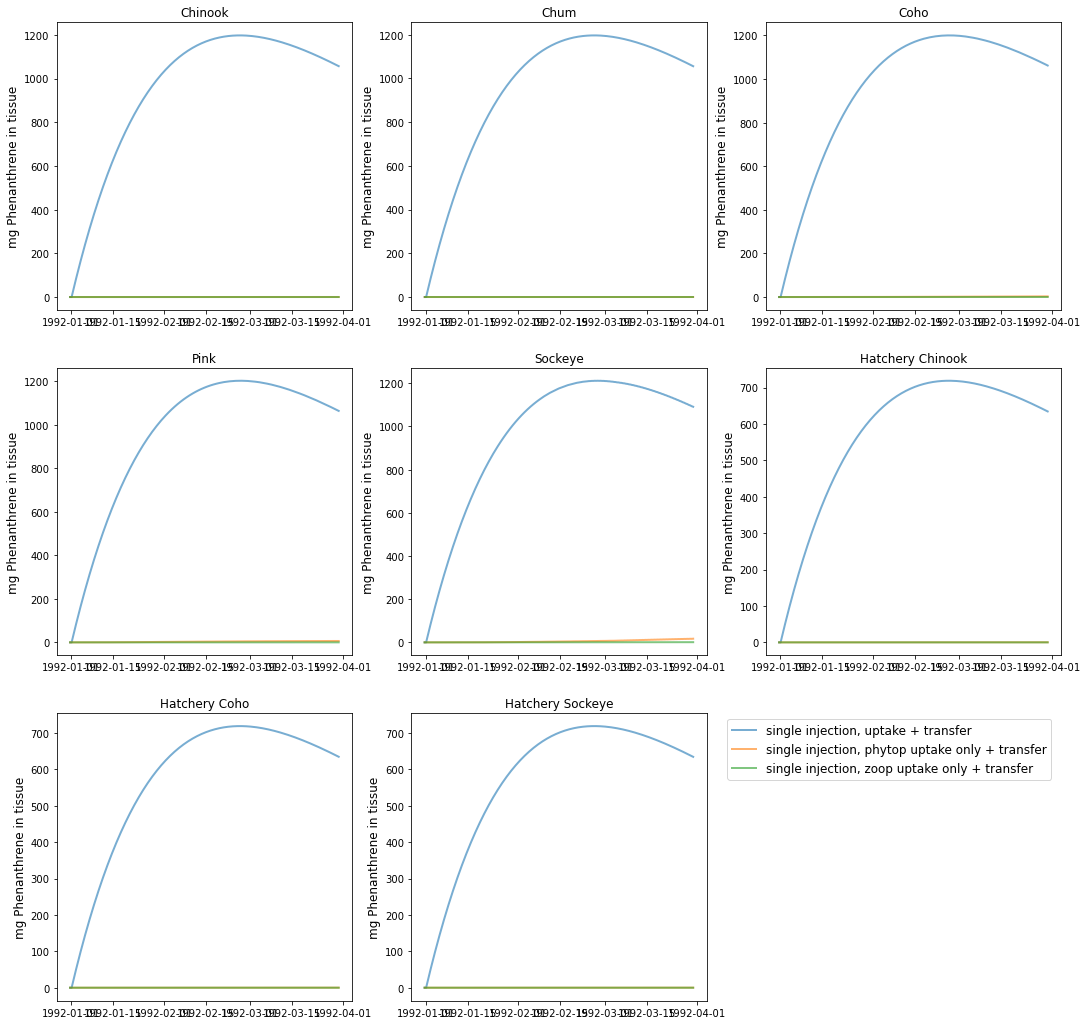

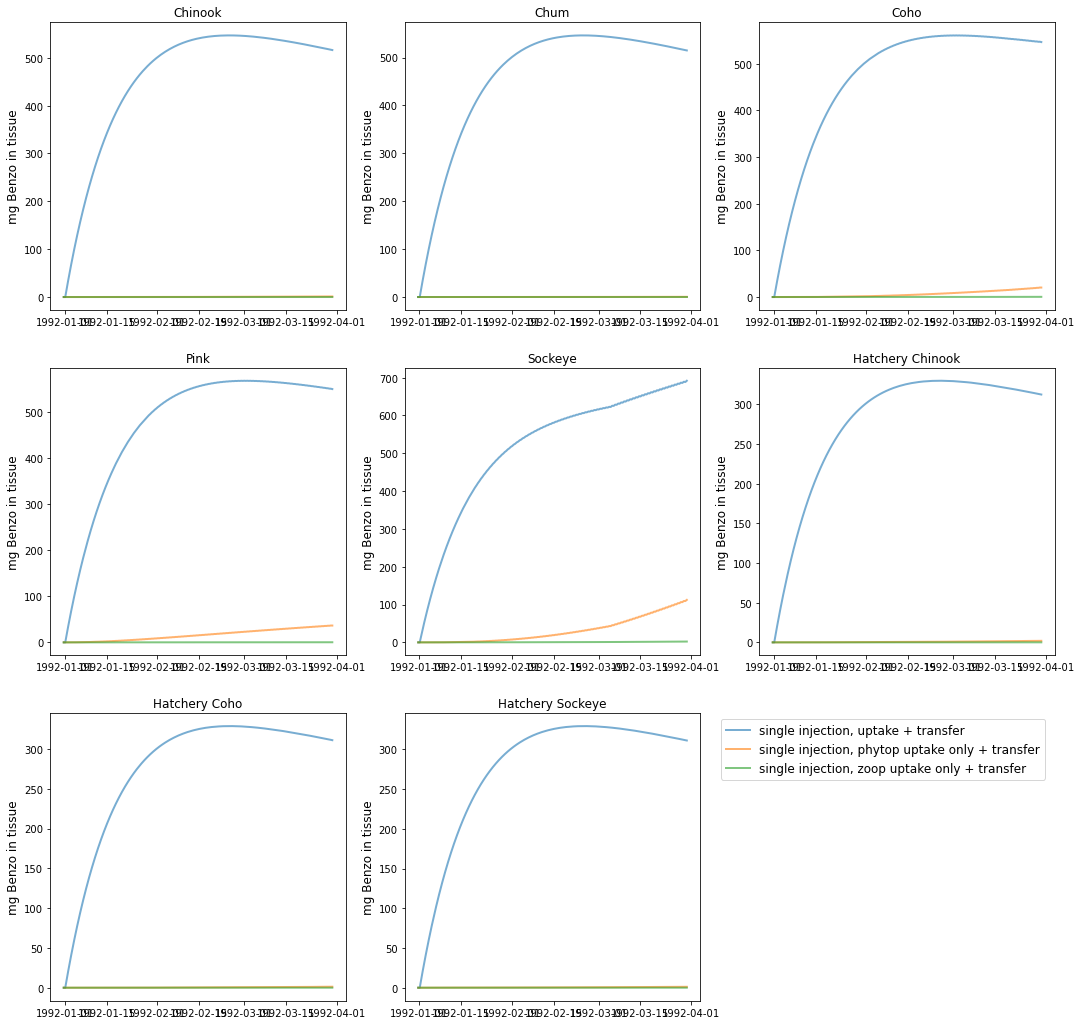

In [38]:
for pah in groups.pahs:
    tissue_vertebrate_mass(groups.salmon, pah, scenarios, labels)

Direct uptake dominates the mass of PAH inside salmon tissue

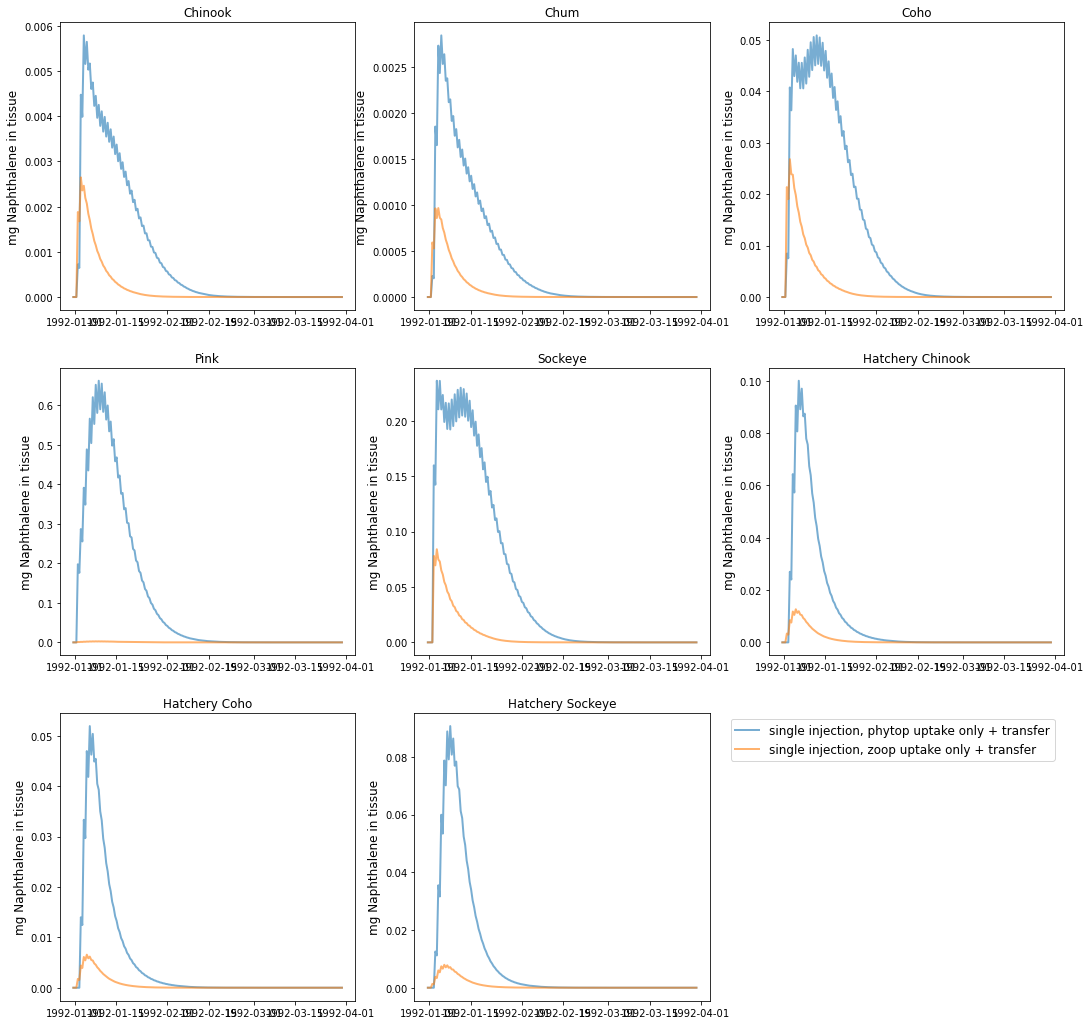

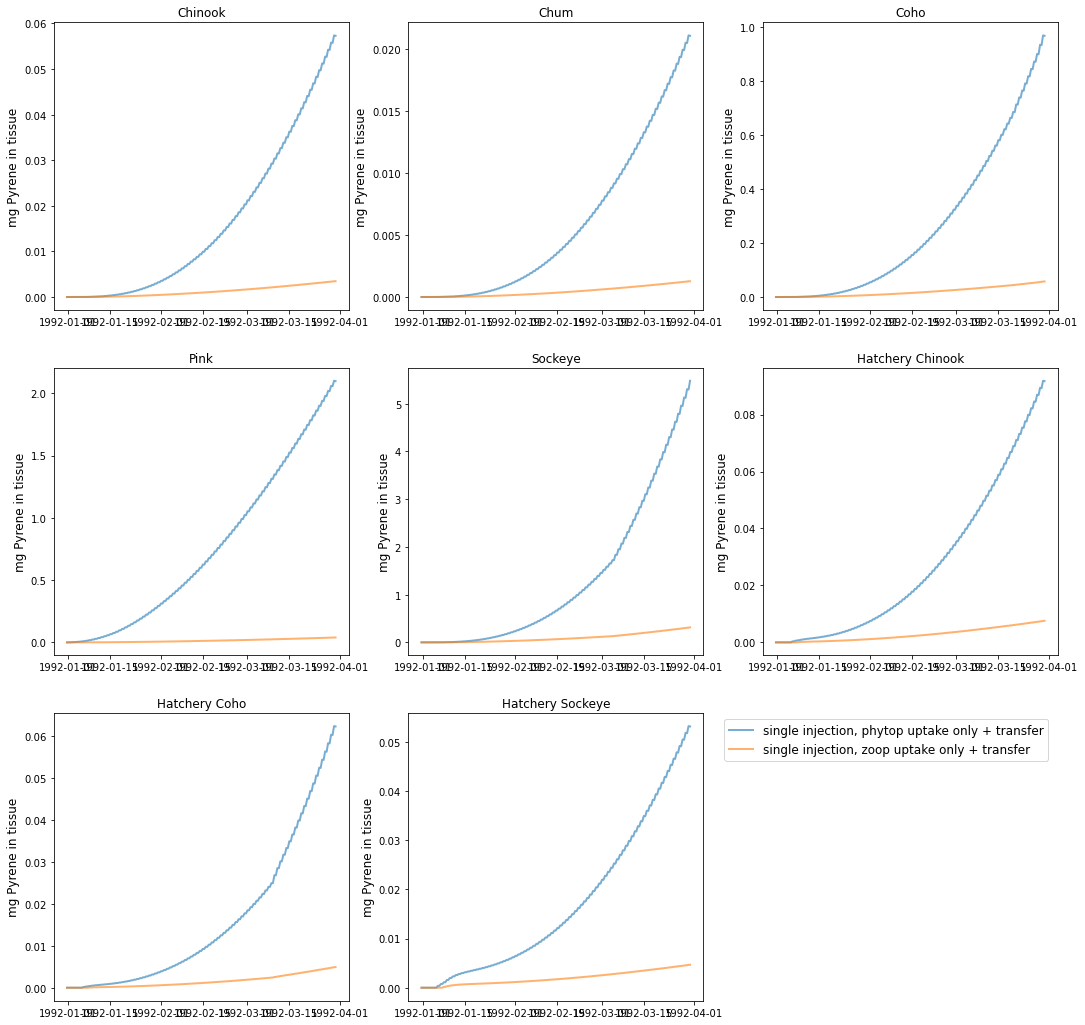

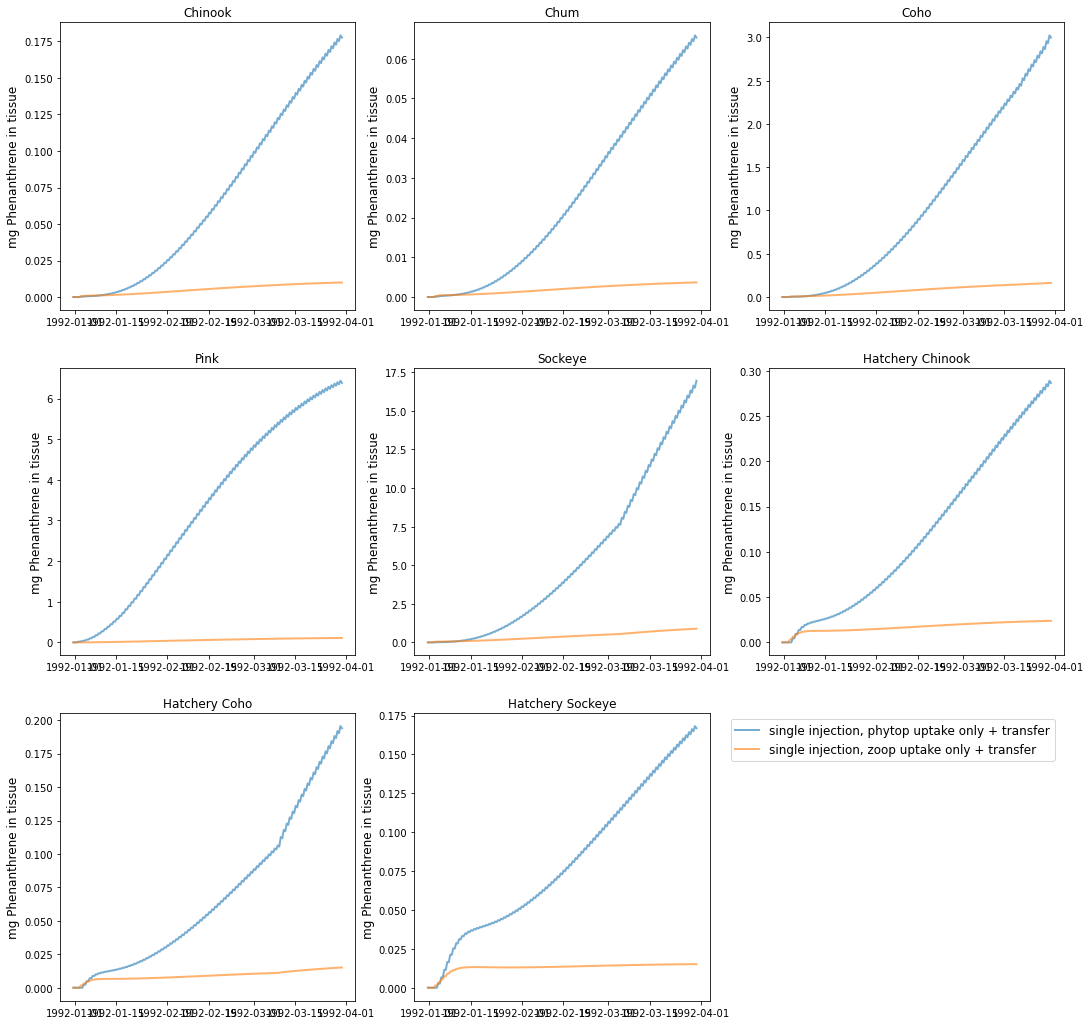

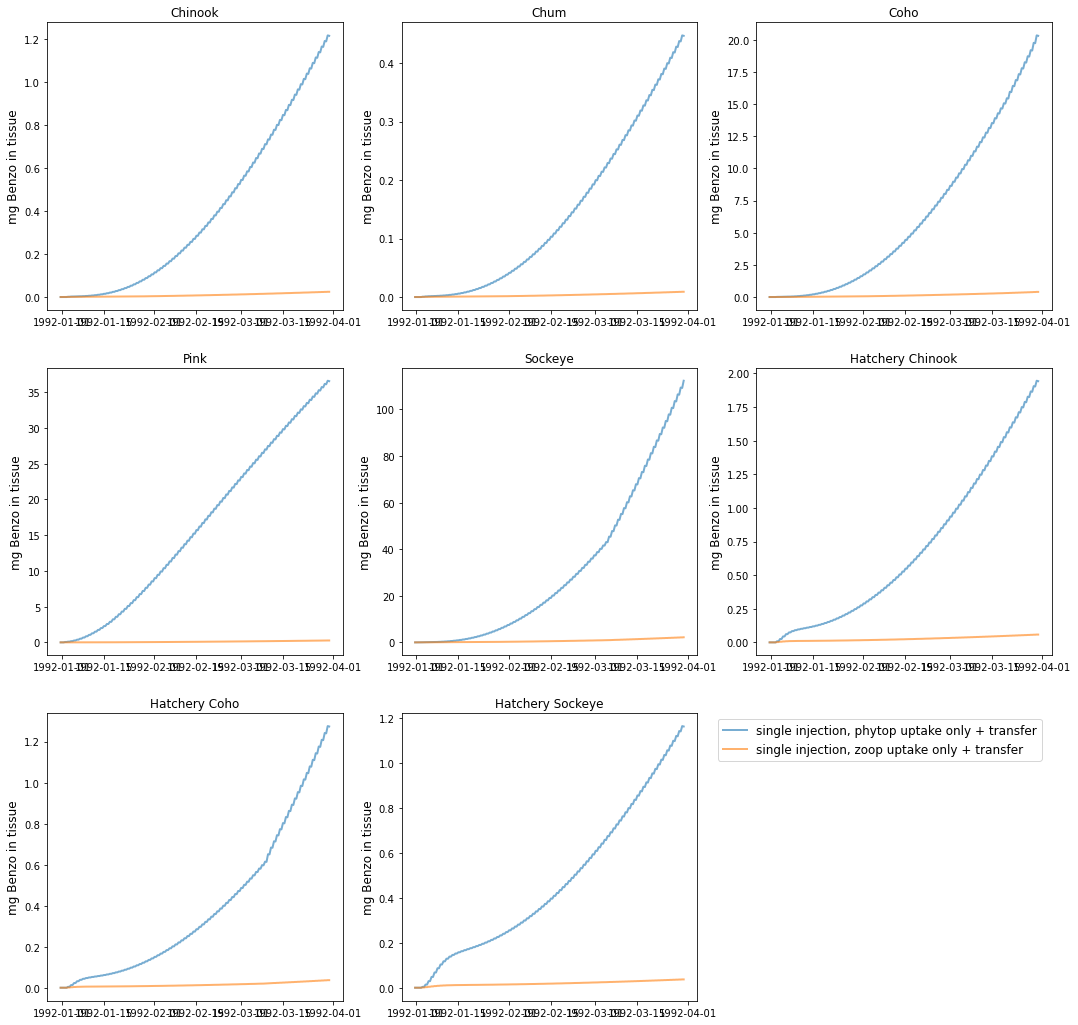

In [43]:
for pah in groups.pahs:
    tissue_vertebrate_mass(groups.salmon, pah, scens, testlabels)

Without direct uptake, the contributions from transfer from phytoplankton and zooplankton are evident. Higher contributions from phytoplankton trophic transfer than from zooplankton.

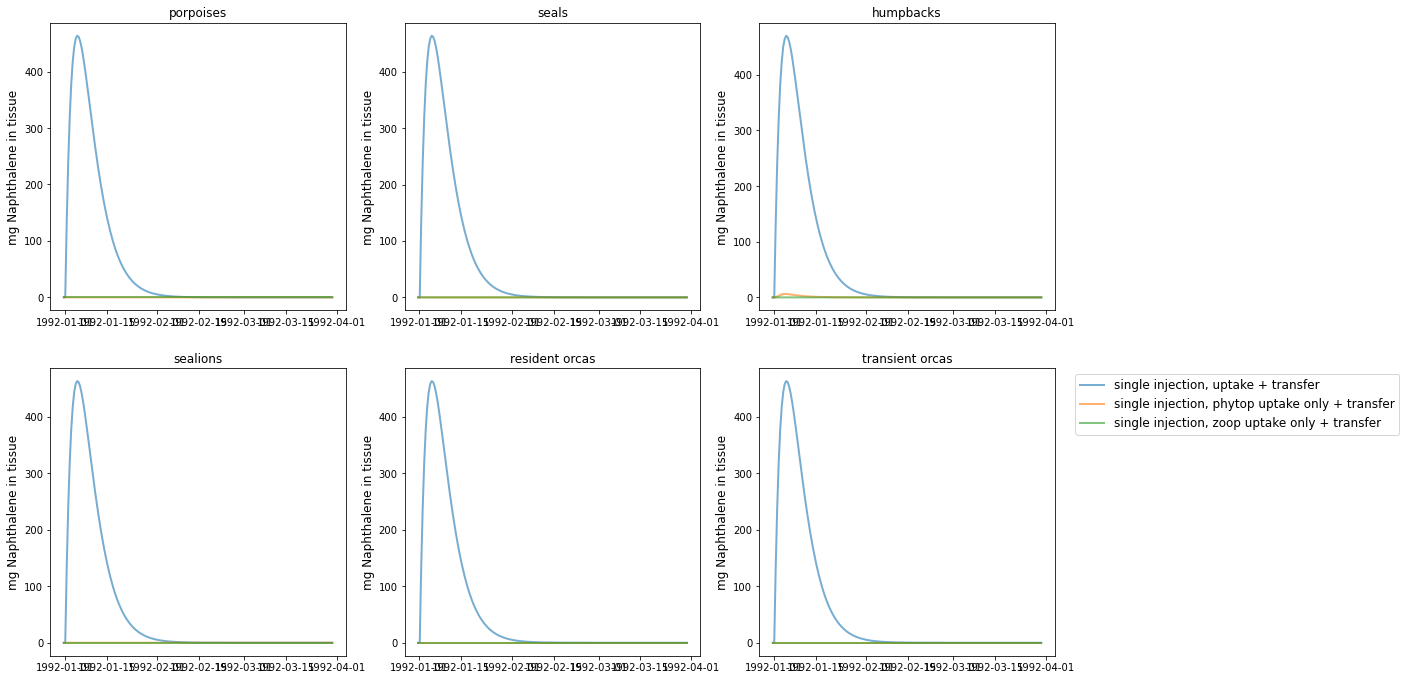

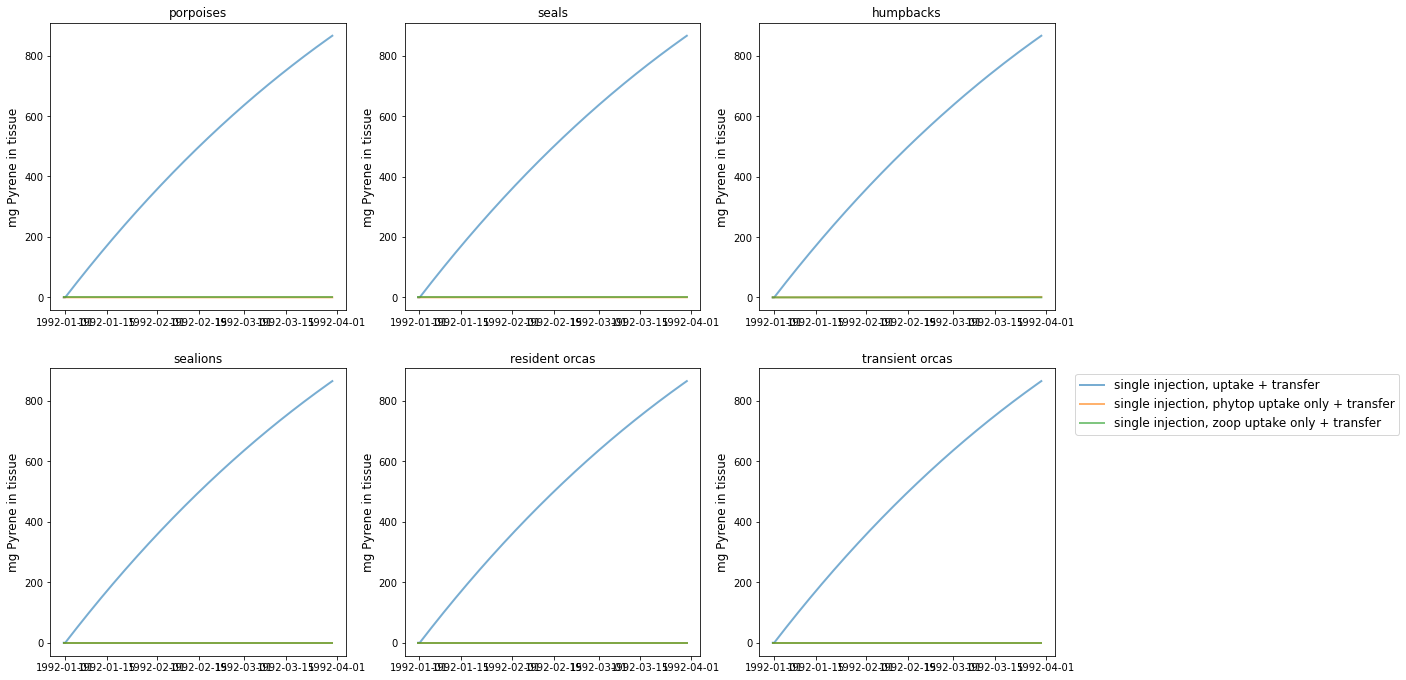

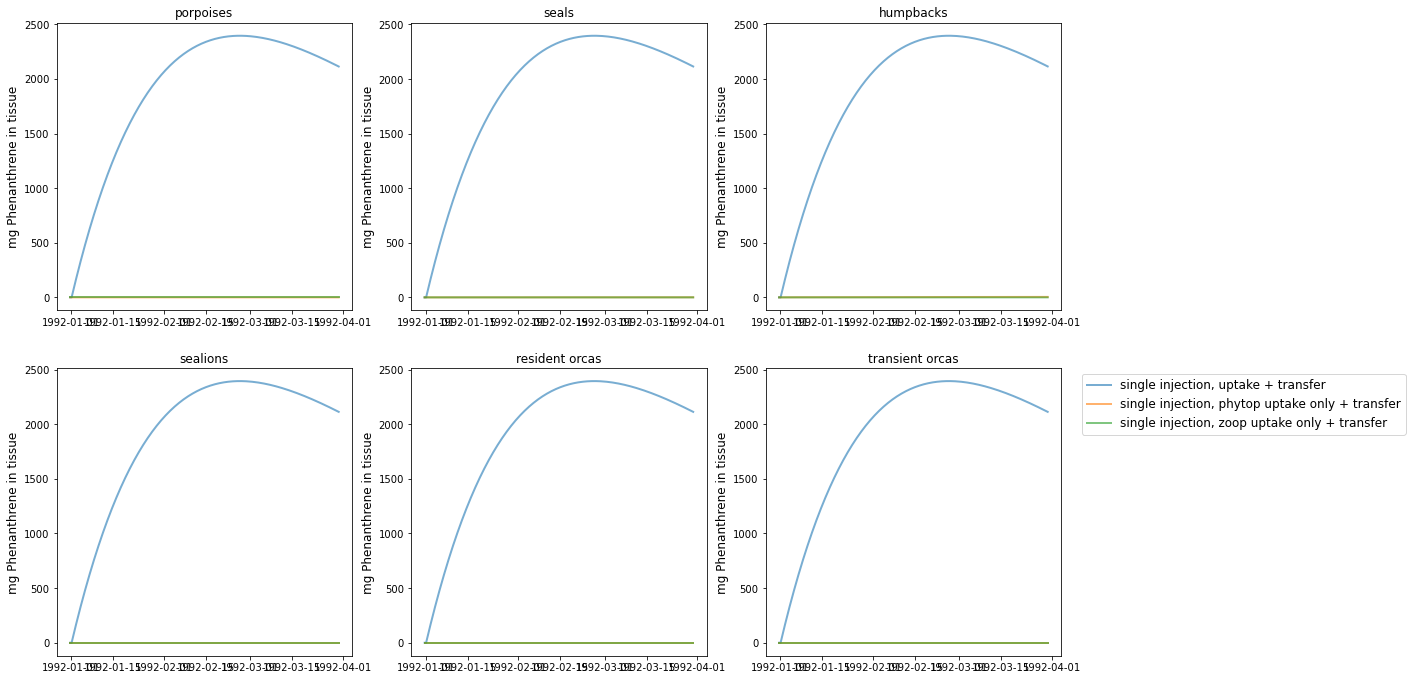

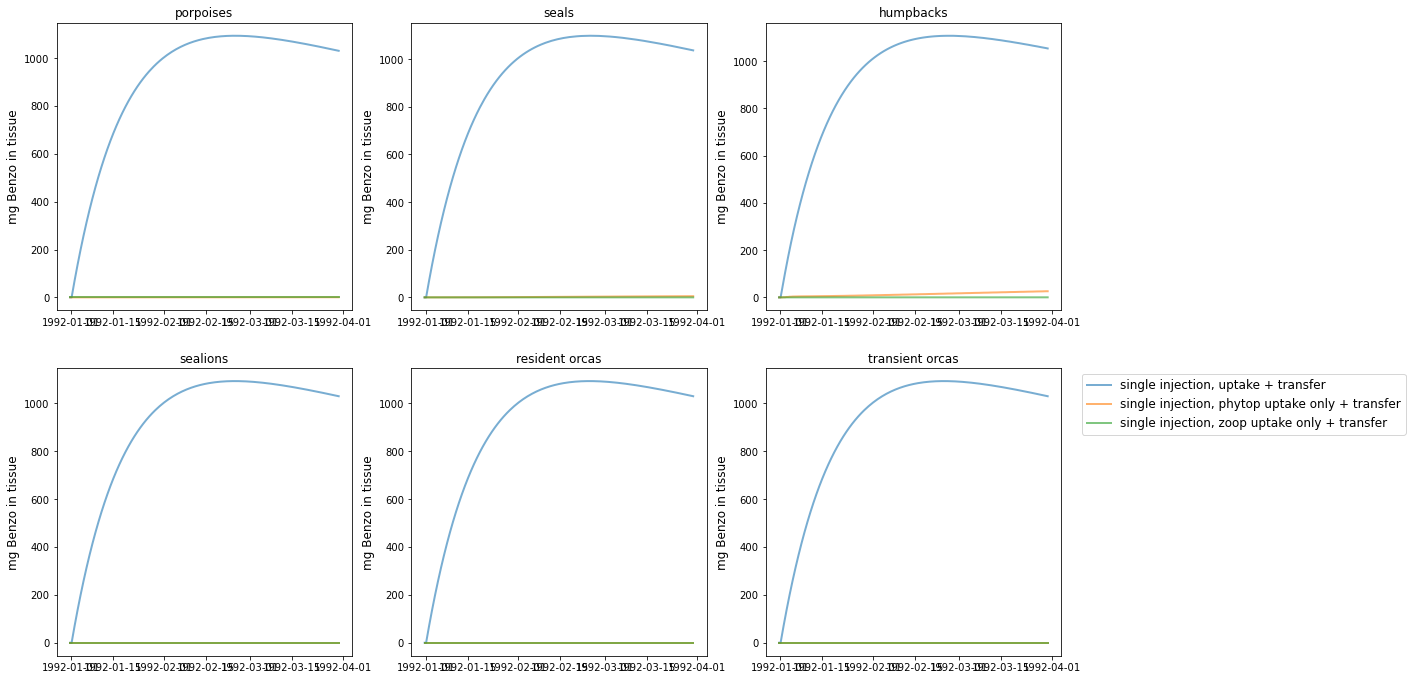

In [40]:
for pah in groups.pahs:
    tissue_vertebrate_mass(groups.mammals, pah, scenarios, labels)

Similar to salmon, direct uptake dominates in the mammmals

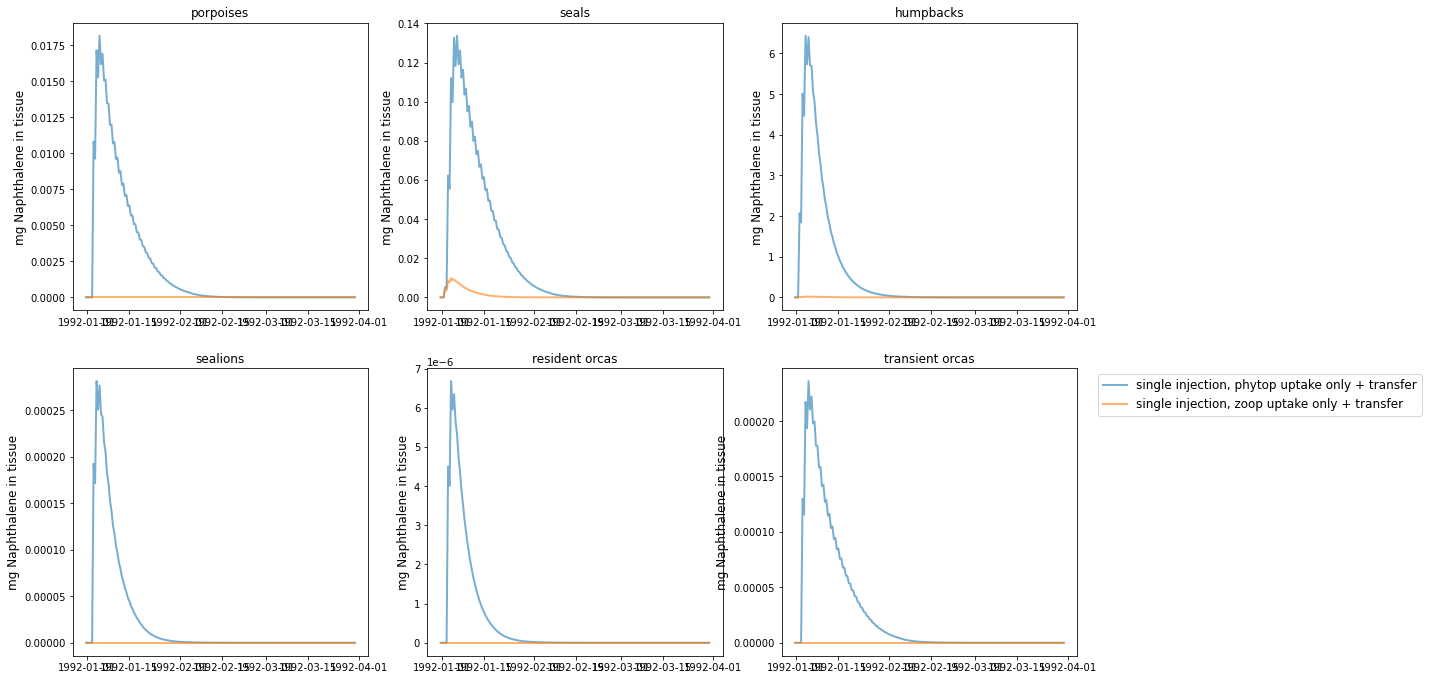

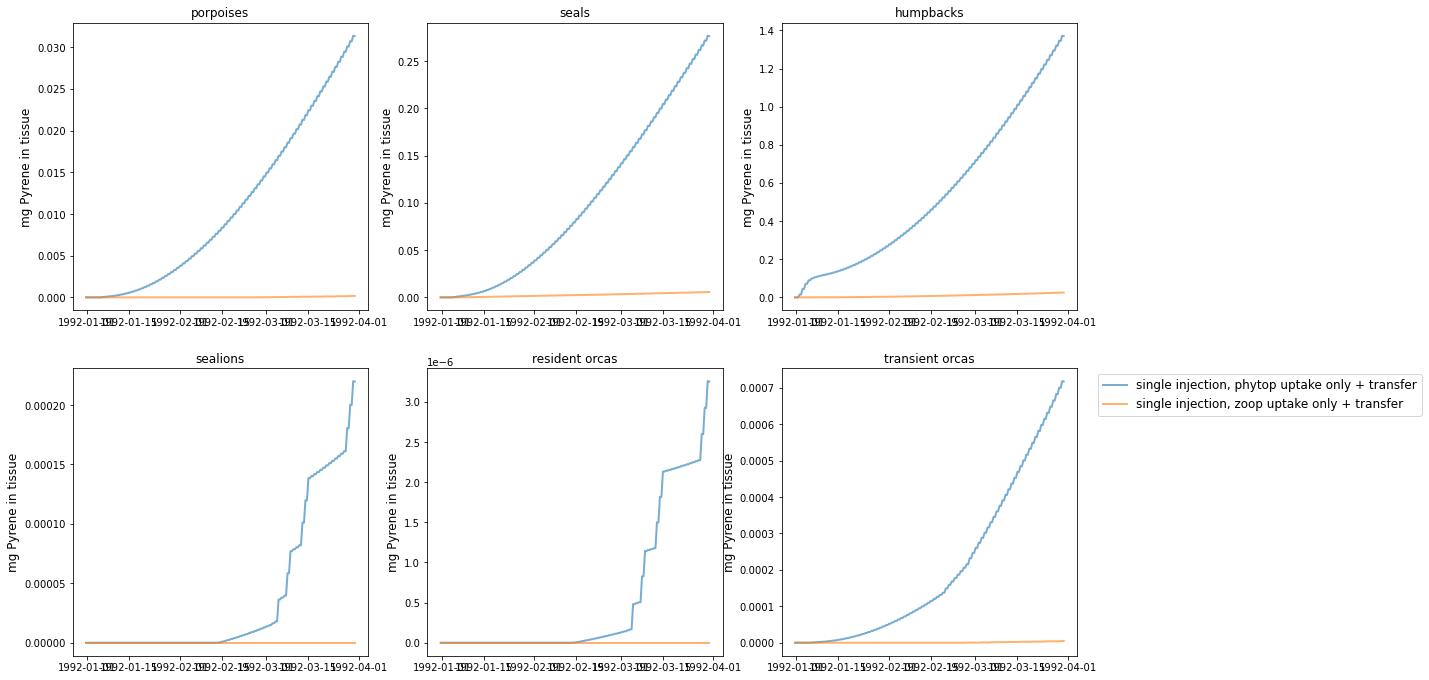

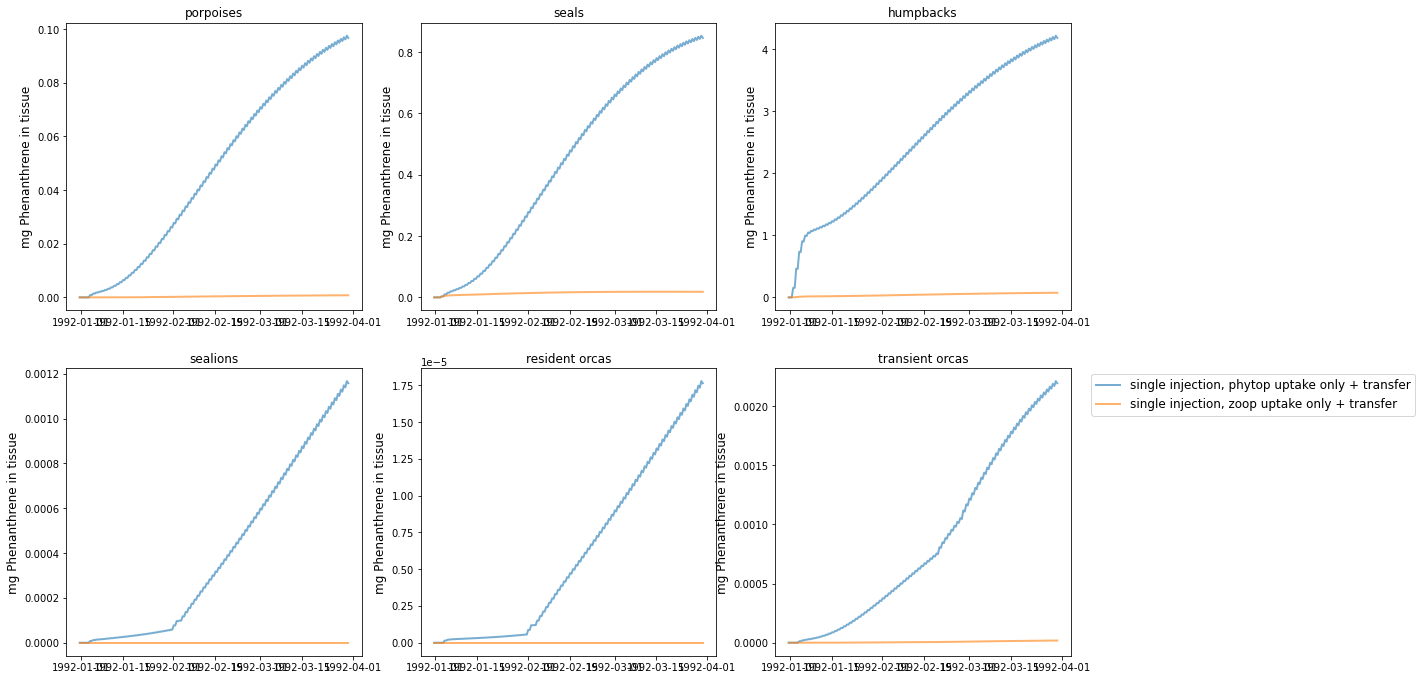

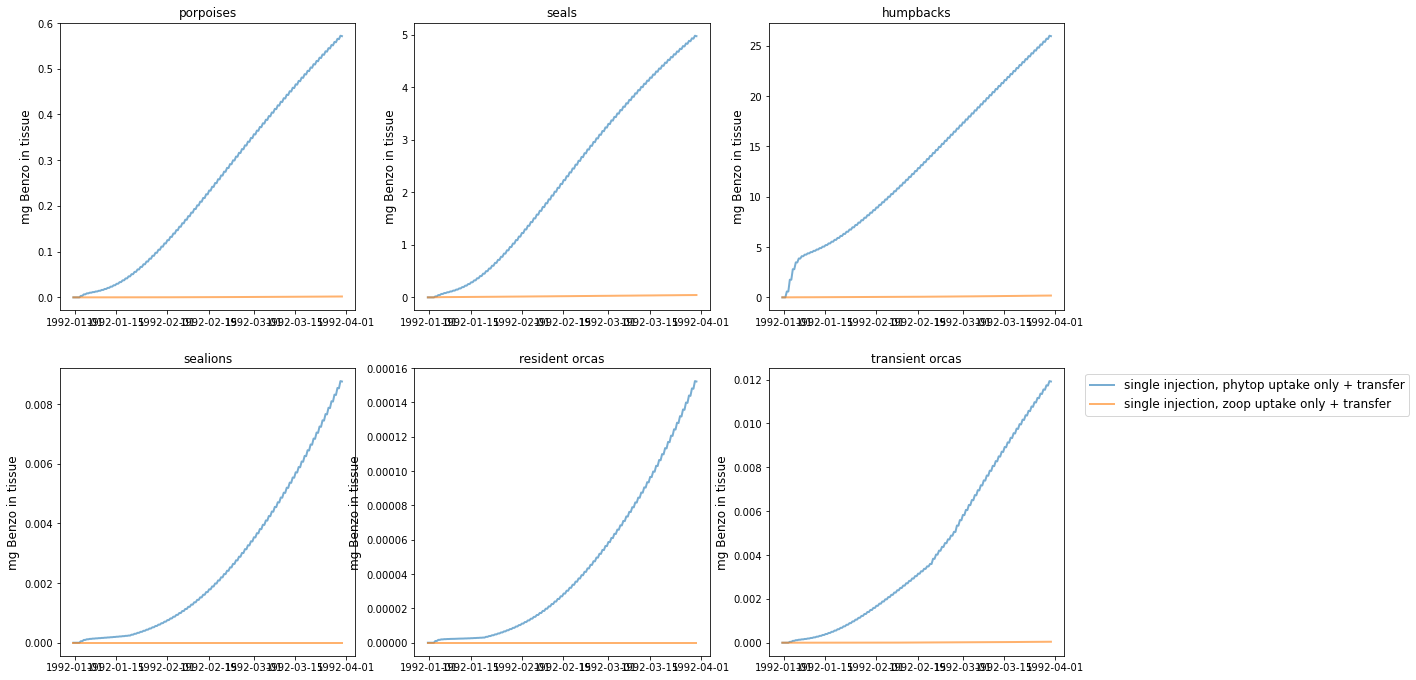

In [44]:
for pah in groups.pahs:
    tissue_vertebrate_mass(groups.mammals, pah, scens, testlabels)

Without direct uptake, contributions are evident from lower trophic levels, with higher contribution from the plankton.